In [1]:
import numpy as np
import pandas as pd
import os as os
import time



In [2]:
os.chdir('../')

In [3]:
%pylab inline
exec(open("./run_model.py").read())
exec(open("./get_signal_names.py").read())
exec(open("./portfolio_optimizer.py").read())

import datetime
from pylab import rcParams
import seaborn as sns
sns.set(color_codes=True)


Populating the interactive namespace from numpy and matplotlib


In [4]:
sig_type = 'rank'
#rank
#norm
size_tag = '500_3000'
#0_3000
#0_500
#500_3000
#use_pickle = True 


    

sig_dir =      '../afp_data/' + sig_type + '/' +  size_tag + '/rps_data/'
fac_data_dir=  '../afp_data/' + sig_type + '/' +  size_tag + '/factor_exposure_data/'
fac_ret_file = '../afp_data/' + sig_type + '/' +  size_tag + '/fac_ret_file.csv'
    

In [5]:
use_pickle = True 

if use_pickle :
    file_name = '../afp_pickle/'+'sig_'+sig_type +'_'+size_tag +'.pkl' 
    sig_df = pd.read_pickle(file_name)
    #sig_df = pd.read_pickle('../afp_pickle/_rank_0_500.pkl')
else :
    sig_df = pd.DataFrame()
    sig_files = os.listdir(sig_dir)
    sig_files = np.sort(sig_files)



    for sig_file in sig_files :
        if '.csv' not in sig_file :
            continue
        print(sig_file)
        this_file = sig_dir + sig_file
        this_df = pd.read_csv(this_file, index_col = 'date')
        this_df.index = [ datetime.datetime.strptime(val, '%Y-%m-%d') for val in this_df.index]
        #this_df = this_df.sort_values(['mve'], ascending=False)
        #this_df = this_df.iloc[start_stock_ind:end_stock_ind,:]
        sig_df = sig_df.append(this_df)
    #data = sig_df.copy()

In [6]:
shrp_df = pd.read_csv('/Users/raghuramkowdeed/Desktop/knn_signals_1.csv', index_col='Unnamed: 0')
shrp_df['org'] = shrp_df['org'].abs()
shrp_df = shrp_df.sort_values('knn', ascending=False)

In [7]:
fil_shrp_df = shrp_df[shrp_df['knn']>0.6]
fil_shrp_df = fil_shrp_df[ (fil_shrp_df['knn']/shrp_df['org'])>1.8]

/Users/raghuramkowdeed/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


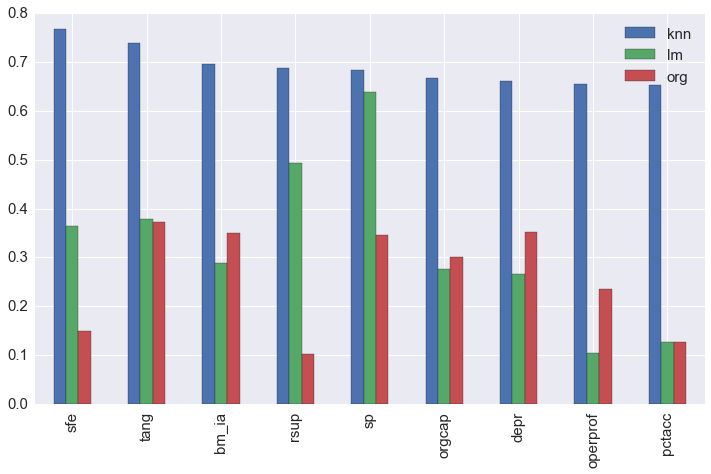

In [47]:
fil_shrp_df.plot(kind='bar', fontsize=15, figsize =  (12,7))
pylab.legend(fontsize=15, loc='best')


In [9]:
sig_name = 'lev'

In [10]:
#model_name = 'linear_regression'
#train_model_arg = { 'fit_intercept':True }

model_name = 'knn'
train_model_arg = None



In [11]:
begin_date = datetime.datetime.strptime('19900101', '%Y%m%d')
end_date = datetime.datetime.strptime('20170101', '%Y%m%d')

sig_df = sig_df[(sig_df.index>=begin_date) & (sig_df.index<end_date)]
sig_df = sig_df.fillna(sig_df.mean())

In [12]:
'res_ret' in sig_df.columns

True

In [13]:
#factor_names =  ['beta','mve', 'bm', 'roic', 'agr', 'mom12m', 'idiovol']
factor_names =  ['beta']
sig_names = get_signal_names()
ret_sr = sig_df['ret']
sig_df = sig_df[sig_names]
sig_df = sig_df.drop(factor_names, axis=1)
sig_df = sig_df.drop(['idiovol'], axis=1)

In [14]:
pm = PortfolioOptimizer(fac_data_dir=fac_data_dir,
                        fac_ret_file = fac_ret_file,
                        fac_cov_hl = 12.0,
                        fac_names = None
                       )

--------


In [15]:
pnl_df = pd.read_csv('./../afp_results/signed_signal_pnl_df.csv',index_col = 'Unnamed: 0')
pnl_df.index = [ datetime.datetime.strptime(val, '%Y-%m-%d')for val in pnl_df.index]

1.25035849574


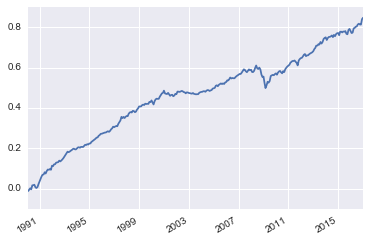

In [16]:
x = pnl_df[['mve', 'bm', 'roic', 'agr', 'mom12m',]]
print( x.mean(axis=1).mean()*sqrt(12)/x.mean(axis=1).std() )
x.mean(axis=1).cumsum().plot()

1.37484937459


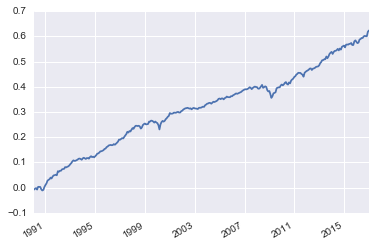

In [17]:
x = pnl_df
print( x.mean(axis=1).mean()*sqrt(12)/x.mean(axis=1).std() )
x.mean(axis=1).cumsum().plot()

In [18]:
look_back = 1

knn_sig_df = pd.DataFrame()
lm_sig_df = pd.DataFrame()
kernel_sig_df = pd.DataFrame()

pnl_df = pd.DataFrame()
lm_pnl_df = pd.DataFrame()
knn_pnl_df = pd.DataFrame()
kernel_pnl_df = pd.DataFrame()

shrp_df = pd.DataFrame()

#these_signals = ['mve', 'bm', 'roic', 'agr', 'mom12m',]
sig_name = 'bm_ia'

try :
    t0 = time.time()

    this_sig_sr = sig_df[ [sig_name] ].copy()
    #unmodified signal
    pnl_sr = pm.run_signal(this_sig_sr.iloc[:,0], neu_sig=True)
    pnl_df[sig_name] = pnl_sr

    #linear signal
    print('lm')
    lm_sig_sr,lm_mvc = run_model( this_sig_sr, ret_sr, model_name='linear_regression', train_model_arg=train_model_arg, 
                      pred_model_arg ={},look_back=look_back, sample_decay = 0.0)
    lm_sig_df[sig_name] = lm_sig_sr
    lm_pnl_sr = pm.run_signal(lm_sig_sr, neu_sig=True)
    lm_pnl_df[sig_name] = lm_pnl_sr

    #knn signal
    print('knn')
    knn_sig_sr,knn_mvc = run_model( this_sig_sr, ret_sr, model_name='knn', train_model_arg=train_model_arg, 
                      pred_model_arg ={},look_back=look_back, sample_decay = 0.0)
    knn_sig_df[sig_name] = knn_sig_sr   
    knn_pnl_sr = pm.run_signal(knn_sig_sr, neu_sig=True)
    knn_pnl_df[sig_name] = knn_pnl_sr

    #kernel signal
    print('kernel')
    kernel_sig_sr, kernel_mvc = run_model( this_sig_sr, ret_sr, model_name='ridge_kernel', train_model_arg=train_model_arg, 
                      pred_model_arg ={},look_back=look_back, sample_decay = 0.5)
    kernel_sig_df[sig_name] = kernel_sig_sr   
    kernel_pnl_sr = pm.run_signal(kernel_sig_sr, neu_sig=True)
    kernel_pnl_df[sig_name] = kernel_pnl_sr


    s1 = pnl_sr.mean()*sqrt(12)/ pnl_sr.std()
    s2 = lm_pnl_sr.mean()*sqrt(12)/ lm_pnl_sr.std()
    s3 = knn_pnl_sr.mean()*sqrt(12)/ knn_pnl_sr.std()
    s4  = kernel_pnl_sr.mean()*sqrt(12)/ kernel_pnl_sr.std()

    this_shrp = pd.Series([s1,s2,s3,s4], index=['org', 'lm', 'knn', 'kernel'], name = sig_name)
    #this_shrp = pd.Series([s1,s2,s3], index=['org', 'lm', 'knn',], name = sig_name)
    shrp_df = shrp_df.append(this_shrp)

    t1 = time.time()
    this_time = t1-t0
    print('time = ' + str(this_time)) 
    print(this_shrp)

except Exception as e :
    print(e)

-----------
lm
1990-02-28 00:00:00
1990-03-30 00:00:00
1990-04-30 00:00:00
1990-05-31 00:00:00
1990-06-29 00:00:00
1990-07-31 00:00:00
1990-08-31 00:00:00
1990-09-28 00:00:00
1990-10-31 00:00:00
1990-11-30 00:00:00
1990-12-31 00:00:00
1991-01-31 00:00:00
1991-02-28 00:00:00
1991-03-28 00:00:00
1991-04-30 00:00:00
1991-05-31 00:00:00
1991-06-28 00:00:00
1991-07-31 00:00:00
1991-08-30 00:00:00
1991-09-30 00:00:00
1991-10-31 00:00:00
1991-11-29 00:00:00
1991-12-31 00:00:00
1992-01-31 00:00:00
1992-02-28 00:00:00
1992-03-31 00:00:00
1992-04-30 00:00:00
1992-05-29 00:00:00
1992-06-30 00:00:00
1992-07-31 00:00:00
1992-08-31 00:00:00
1992-09-30 00:00:00
1992-10-30 00:00:00
1992-11-30 00:00:00
1992-12-31 00:00:00
1993-01-29 00:00:00
1993-02-26 00:00:00
1993-03-31 00:00:00
1993-04-30 00:00:00
1993-05-28 00:00:00
1993-06-30 00:00:00
1993-07-30 00:00:00
1993-08-31 00:00:00
1993-09-30 00:00:00
1993-10-29 00:00:00
1993-11-30 00:00:00
1993-12-31 00:00:00
1994-01-31 00:00:00
1994-02-28 00:00:00
1994-

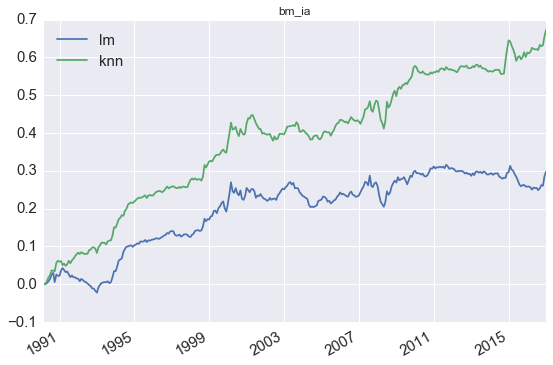

In [42]:
this_df = pd.DataFrame()
this_df['lm'] = lm_pnl_df.iloc[:,0]
this_df['knn'] = kernel_pnl_df.iloc[:,0]
this_df.cumsum().plot(fontsize=15, figsize =  (9,6))
pylab.legend(fontsize=15, loc='best')
pylab.title('bm_ia')

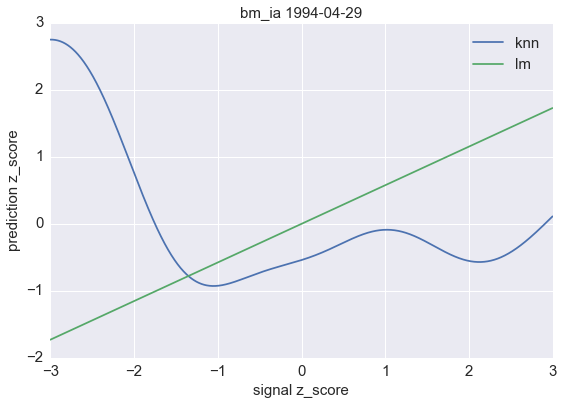

In [46]:
ind = 50
this_dt = kernel_pnl_sr.index[ind]

lm_m = lm_mvc[ind]
knn_m = knn_mvc[ind]
kernel_m = kernel_mvc[ind]

x = np.arange(-3.0,3.0, 0.005)
x = x.reshape(x.shape[0],1)
kernel_y = kernel_m.predict(x)
#knn_y = knn_m.predict(x)
lm_y = lm_m.predict(x)

this_df = pd.DataFrame()
this_df['knn'] = kernel_y
#this_df['knn'] = knn_y
this_df['lm'] = lm_y
this_df = ( this_df - this_df.mean() ) /this_df.std()
this_df.index = x
this_df.plot(fontsize=15, figsize =  (9,6))
pylab.legend(fontsize=15, loc='best')
pylab.title( 'bm_ia '+ str(this_dt.date()), fontsize=15)
pylab.xlabel('signal z_score', fontsize=15)
pylab.ylabel('prediction z_score', fontsize=15)
